In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
token = os.path.join(os.environ['HOME'],'code/cel/auth/spacescope_auth.json')

# Simulation parameters
# forecast_start_date = date.today() - timedelta(days=3)
forecast_start_date = date(2024, 1, 28)  # fix to avoid tuning factors
current_date = forecast_start_date

start_date = current_date - timedelta(days=3) # get some historical data
current_day = (current_date-start_date).days
forecast_length = 365*3
end_date = current_date + timedelta(days=forecast_length)

## FIP implementation parameters
# update_day = pd.to_datetime('2024-09-01')
update_day = pd.to_datetime('2024-03-01')


In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/baseline_bugfix_v3')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [5]:
pystarboard.data.setup_spacescope(token)

In [6]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

In [7]:
#reconstruct historical power onboarding/pledge/fofr metrics
hist_df = pystarboard.data.get_historical_network_stats(start_date-timedelta(days=360), current_date, end_date)
hist_expire_df = pystarboard.data.query_sector_expirations(start_date-timedelta(days=360), current_date)
hist_df['date'] = pd.to_datetime(hist_df['date'])
hist_df.sort_values('date', inplace=True)
hist_expire_df['date'] = pd.to_datetime(hist_expire_df['date']).dt.tz_localize(None)
hist_expire_df.sort_values('date', inplace=True)
hist_df_merged = pd.merge_asof(hist_df, hist_expire_df, on='date')

hist_econ_df = pystarboard.data.query_sector_economics(
    start_date-timedelta(days=360), 
    current_date, 
)
pledge_historical = hist_econ_df[['date', 'sector_initial_pledge_32gib']]
pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])
    
hist_df_merged = pd.merge_asof(hist_df_merged, pledge_historical, on='date')
# now add the quantities of interest
hist_df_merged['day_network_reward'] = hist_df_merged['mined_fil'].diff()
hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]
hist_df_merged['day_locked_pledge'] = hist_df_merged['locked_fil'].diff()
hist_df_merged['day_renewed_pledge'] = hist_df_merged['extended_pledge'].diff()

hist_df_merged['day_rewards_per_sector'] = C.EIB_PER_SECTOR * hist_df_merged['day_network_reward'] / hist_df_merged['total_qa_power_eib']

/tmp/ipykernel_17227/1594423701.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])
/tmp/ipykernel_17227/1594423701.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]


In [8]:
def create_gamma_vector(upgrade_date, forecast_length, current_date, ramp_len_days=90):
    gamma_smooth = np.ones(forecast_length)
    update_day = (upgrade_date-pd.to_datetime(current_date)).days

    ramp_gamma = np.linspace(1, 0.7, ramp_len_days)
    
    ramp_start_idx = update_day
    ramp_end_idx = min(forecast_length, ramp_start_idx + ramp_len_days)
    gamma_smooth[ramp_start_idx:ramp_end_idx] = ramp_gamma[0:(ramp_end_idx-ramp_start_idx)]
    gamma_smooth[ramp_end_idx:] = 0.7
    return gamma_smooth

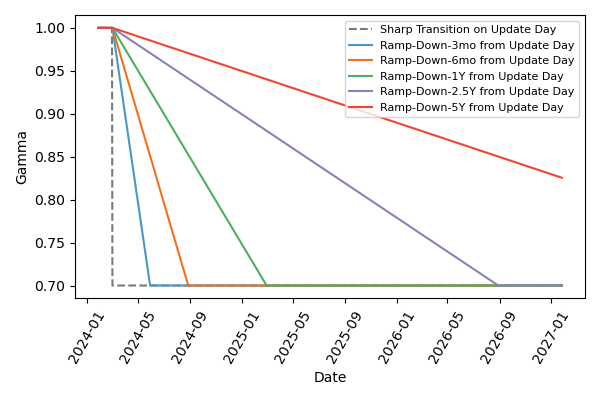

In [9]:
# show the difference between smooth ramp-up of pledge vs. sudden increase
# by modeling the gamma parameter as a vector that switches from 1 to 0.7 as a step function vs. a smooth ramp
no_gamma = np.ones(forecast_length)

gamma_sharp = np.ones(forecast_length)
forecast_t = pd.date_range(current_date, periods=forecast_length, freq='D')
gamma_sharp[forecast_t >= update_day] = 0.7

gamma_smooth_3mo = create_gamma_vector(update_day, forecast_length, current_date, ramp_len_days=int(90))
gamma_smooth_6mo = create_gamma_vector(update_day, forecast_length, current_date, ramp_len_days=int(180))
gamma_smooth_1y = create_gamma_vector(update_day, forecast_length, current_date, ramp_len_days=int(365))
gamma_smooth_2_5y = create_gamma_vector(update_day, forecast_length, current_date, ramp_len_days=int(2.5*365))
gamma_smooth_5y = create_gamma_vector(update_day, forecast_length, current_date, ramp_len_days=int(5*365))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds'], mpl.colormaps['Greys']]
ax.plot(forecast_t, gamma_sharp, label='Sharp Transition on Update Day', color=colors[-1](0.6), linestyle='--')
ax.plot(forecast_t, gamma_smooth_3mo, label='Ramp-Down-3mo from Update Day', color=colors[0](0.6))
ax.plot(forecast_t, gamma_smooth_6mo, label='Ramp-Down-6mo from Update Day', color=colors[1](0.6))
ax.plot(forecast_t, gamma_smooth_1y, label='Ramp-Down-1Y from Update Day', color=colors[2](0.6))
ax.plot(forecast_t, gamma_smooth_2_5y, label='Ramp-Down-2.5Y from Update Day', color=colors[3](0.6))
ax.plot(forecast_t, gamma_smooth_5y, label='Ramp-Down-5Y from Update Day', color=colors[4](0.6))
ax.set_ylabel('Gamma') 
ax.set_xlabel('Date')
ax.legend(fontsize=8)
for tick in ax.get_xticklabels(): tick.set_rotation(60)

gammastr2vec = {
    'sharp': gamma_sharp,
    'smooth_3mo': gamma_smooth_3mo,
    'smooth_6mo': gamma_smooth_6mo,
    'smooth_1y': gamma_smooth_1y,
    'smooth_2_5y': gamma_smooth_2_5y,
    'smooth_5y': gamma_smooth_5y,
}

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'gamma_comparison.png'), dpi=300)

In [10]:
# get additional historical data for plotting purposes
hist_plot_tvec_rr, historical_rr = u.get_historical_renewal_rate(current_date-timedelta(days=90), current_date)
hist_plot_tvec_rbp, historical_rb = u.get_historical_daily_onboarded_power(current_date-timedelta(days=90), current_date)
hist_plot_tvec_fpr, historical_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=90), current_date)

In [11]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [12]:
# plot difference in supply related statistics 
def plot_supply(results_dict):
    # locked, cs, locked/cs
    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,4))

    
    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    # axx = ax[0, 0]
    axx = ax[0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.axhline(100/3, color=colors[1](0.2), linestyle='--', linewidth=0.5, label='100M USD @ $3/FIL')
    axx.axhline(100/5, color=colors[1](0.5), linestyle='--', linewidth=0.5, label='100M USD @ $5/FIL')
    axx.axhline(100/10, color=colors[1](0.8), linestyle='--', linewidth=0.5, label='100M USD @ $10/FIL')
    axx.legend(fontsize=8, loc='lower left')
    axx.set_ylim(bottom=0)

    axx = ax[1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['circ_supply']/1e6, color=c, linestyle=linestyle, label=gamma_str)
    axx.plot(hist_df_merged['date'], hist_df_merged['circulating_fil']/1e6, color='k', linestyle=linestyle)
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    axx.legend(fontsize=8)

    axx = ax[2]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['network_locked']/sim_results['circ_supply'] * 100, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/hist_df_merged['circulating_fil']*100, color='k')
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'supply.png'))

def plot_onboarding(results_dict):
    # locked, cs, locked/cs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['sector_initial_pledge_32gib'], color='k')
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QAP Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]

        dpqq_full = np.concatenate([hist_df_merged['sector_initial_pledge_32gib'].values, sim_results['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sim_results['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(roi_1y), freq='D')
        axx.plot(fofr_tvec, roi_1y*100, color=c, linestyle=linestyle)
        
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'onboarding.png'))

def plot_power(results_dict):
    # rbp, qap, minting
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['rb_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network RBP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[2]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['day_network_reward'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['day_network_reward'], color='k')
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    
    # plt.suptitle('Onboarding Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'power.png'))

def plot_custom(results_dict, suptitle=''):
    # rbp, qap, minting
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['rb_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network RBP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5)
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5)
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[2]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.axhline(100/3, color=colors[1](0.2), linestyle='--', linewidth=0.5, label='100M USD @ $3/FIL')
    axx.axhline(100/5, color=colors[1](0.5), linestyle='--', linewidth=0.5, label='100M USD @ $5/FIL')
    axx.axhline(100/10, color=colors[1](0.8), linestyle='--', linewidth=0.5, label='100M USD @ $10/FIL')
    axx.legend(fontsize=7, loc='upper right')
    axx.set_ylim(bottom=0)
    
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'custom.png'))

def plot_custom2(results_dict, suptitle=''):
    # rbp, qap, minting
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0,0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['rb_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network RBP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5)
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5)
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)

    axx = ax[0,1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[1,0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.axhline(100/3, color=colors[1](0.2), linestyle='--', linewidth=0.5, label='100M USD @ $3/FIL')
    axx.axhline(100/5, color=colors[1](0.5), linestyle='--', linewidth=0.5, label='100M USD @ $5/FIL')
    axx.axhline(100/10, color=colors[1](0.8), linestyle='--', linewidth=0.5, label='100M USD @ $10/FIL')
    axx.legend(fontsize=7, loc='upper right')
    axx.set_ylim(bottom=0)

    axx = ax[1,1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['sector_initial_pledge_32gib'], color='k')
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=7, loc='upper right')
    axx.set_ylim(bottom=0)
    
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'custom2.png'))

def plot_custom3(results_dict, suptitle=''):
    # rbp, qap, minting
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]
    greys = mpl.colormaps['Greys']
    # intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0,0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, label=gamma_str, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('Network QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)

    axx = ax[0,1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    # axx.axhline(100/3, color=colors[1](0.2), linestyle='--', linewidth=0.5, label='100M USD @ $3/FIL')
    # axx.axhline(100/5, color=colors[1](0.5), linestyle='--', linewidth=0.5, label='100M USD @ $5/FIL')
    # axx.axhline(100/10, color=colors[1](0.8), linestyle='--', linewidth=0.5, label='100M USD @ $10/FIL')
    axx.legend(fontsize=7, loc='upper right')
    # axx.set_ylim(bottom=0)

    axx = ax[1,0]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, linestyle=linestyle)
    axx.plot(hist_df_merged['date'], hist_df_merged['sector_initial_pledge_32gib'], color='k')
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.legend(fontsize=7, loc='upper right')
    axx.set_ylim(bottom=0)

    axx = ax[1,1]
    for ii, (sim_config, sim_results) in enumerate(results_dict.items()):
        gamma_str = sim_config[0]
        c = mpl.colormaps[sim_config[4]](0.6)
        linestyle = sim_config[5]
        
        dpqq_full = np.concatenate([hist_df_merged['sector_initial_pledge_32gib'].values, sim_results['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sim_results['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(roi_1y), freq='D')
        axx.plot(fofr_tvec, roi_1y*100, color=c, linestyle=linestyle, label=gamma_str)
        
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color=greys(0.2), linestyle='--', linewidth=0.5, label='Simulation Start')
    axx.axvline(update_day, color=greys(0.6), linestyle='--', linewidth=0.5, label='Update Day')
    axx.set_ylim(bottom=0)
    axx.legend(fontsize=7)
    
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'custom3.png'))

In [13]:
# run the simulations with different configurations of gamma
hist_median_rbp = np.median(historical_rb)
hist_median_rr = np.median(historical_rr)
hist_median_fpr = np.median(historical_fpr)
lock_target = 0.3
sector_duration = 365
FIL_price = 5

sim_configs = [
    # ('Sharp Transition-1x', 'sharp', (1.0, 1.0, 1.0), 1.0, 'Greys', '-'),  # baseline
    # ('Rampdown-2.5Y-1x', 'smooth_2y', (1.0, 1.0, 1.0), 1, 'Blues', '-'), # simulat the pledge-arb w/ the ramped version
    # ('Rampdown-2.5Y-0.8x', 'smooth_2y', (1.0, 1.0, 1.0), 0.8, 'Oranges', '-'), # simulat the pledge-arb w/ the ramped version
    
    ('Sharp Transition-1x', 'sharp', 1.0, 1.0, 'Greys', '-'),  # baseline
    ('Rampdown-3mo-0.8x', 'smooth_3mo', 1.0, 0.8, 'Blues', '-'), # simulat the pledge-arb w/ the ramped version
    ('Rampdown-6mo-0.8x', 'smooth_6mo', 1.0, 0.8, 'Oranges', '-'), # simulat the pledge-arb w/ the ramped version
    ('Rampdown-1y-0.8x', 'smooth_1y', 1.0, 0.8, 'Greens', '-'), # simulat the pledge-arb w/ the ramped version
    ('Rampdown-2.5Y-0.8x', 'smooth_2_5y', 1.0, 0.8, 'Purples', '-'), # simulat the pledge-arb w/ the ramped version
    ('Rampdown-5Y-0.8x', 'smooth_5y', 1.0, 0.8, 'Reds', '-'), # simulat the pledge-arb w/ the ramped version
]
# suptitle = 'Power Invariant'
# suptitle = 'TVL Invariant'
suptitle = 'Power Invariant Upside'

simconfig2results = {}
for sim_config in sim_configs:
    gamma_str, gamma_config_str, rbp_factor, rr_factor, _, _ = sim_config
    gamma_config = gammastr2vec[gamma_config_str]

    rbp_vec_rr09 = np.ones(forecast_length) * hist_median_rbp * rbp_factor

    rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * rr_factor)
    fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
    simulation_results = sim.run_sim(
        rbp_vec_rr09,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data,
        gamma=gamma_config,
        gamma_weight_type=0  # means arithmetic weighting
    )
    simconfig2results[sim_config] = simulation_results

    # compute total investment level and print
    y_val_fil_new = simulation_results['day_locked_pledge'] - simulation_results['day_renewed_pledge']
    y_val_musd = (y_val_fil_new*FIL_price)/1e6
    ix_start = (current_date-start_date).days
    investment_needed = np.sum(y_val_musd[ix_start:])
    annualized_investment = investment_needed / 3
    y1_locked = np.sum(simulation_results['day_locked_pledge'][ix_start:ix_start+365])/1e6
    y2_locked = np.sum(simulation_results['day_locked_pledge'][ix_start+365:ix_start+2*365])/1e6
    y3_locked = np.sum(simulation_results['day_locked_pledge'][ix_start+2*365:ix_start+3*365])/1e6
    total_locked = np.sum(simulation_results['day_locked_pledge'][ix_start:ix_start+3*365])/1e6
    print('>' * 5)
    print(sim_config)
    print(np.sum(simulation_results['day_locked_pledge'][ix_start:])/1e6, np.sum(simulation_results['day_renewed_pledge'][ix_start:])/1e6)
    print('Y1-Locked: %.2fM Y2-Locked: %.2fM Y3-Locked: %.2fM Total-Locked: %.2fM' % (y1_locked, y2_locked, y3_locked, total_locked))
    print('AnnualizedInvestment: $%0.2fM' % (annualized_investment,))
    print('<' * 5)

>>>>>
('Sharp Transition-1x', 'sharp', 1.0, 1.0, 'Greys', '-')
483.4678 307.73914
Y1-Locked: 163.98M Y2-Locked: 169.82M Y3-Locked: 149.67M Total-Locked: 483.47M
AnnualizedInvestment: $292.88M
<<<<<
>>>>>
('Rampdown-3mo-0.8x', 'smooth_3mo', 1.0, 0.8, 'Blues', '-')
422.02393 228.10922
Y1-Locked: 147.11M Y2-Locked: 146.32M Y3-Locked: 128.60M Total-Locked: 422.02M
AnnualizedInvestment: $323.19M
<<<<<
>>>>>
('Rampdown-6mo-0.8x', 'smooth_6mo', 1.0, 0.8, 'Oranges', '-')
419.98975 226.85542
Y1-Locked: 145.78M Y2-Locked: 145.82M Y3-Locked: 128.39M Total-Locked: 419.99M
AnnualizedInvestment: $321.89M
<<<<<
>>>>>
('Rampdown-1y-0.8x', 'smooth_1y', 1.0, 0.8, 'Greens', '-')
414.50696 223.87288
Y1-Locked: 142.29M Y2-Locked: 144.41M Y3-Locked: 127.80M Total-Locked: 414.51M
AnnualizedInvestment: $317.72M
<<<<<
>>>>>
('Rampdown-2.5Y-0.8x', 'smooth_2_5y', 1.0, 0.8, 'Purples', '-')
391.8846 216.38493
Y1-Locked: 138.58M Y2-Locked: 132.13M Y3-Locked: 121.17M Total-Locked: 391.88M
AnnualizedInvestment: $292.

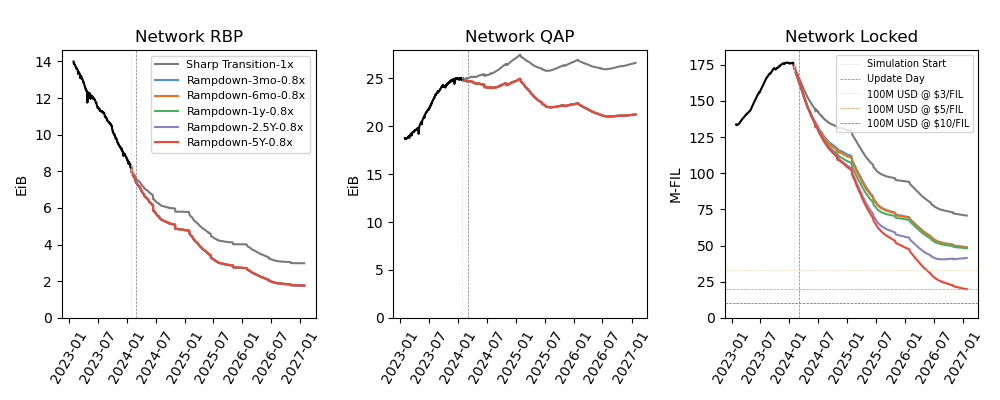

In [14]:
plot_custom(simconfig2results, '')

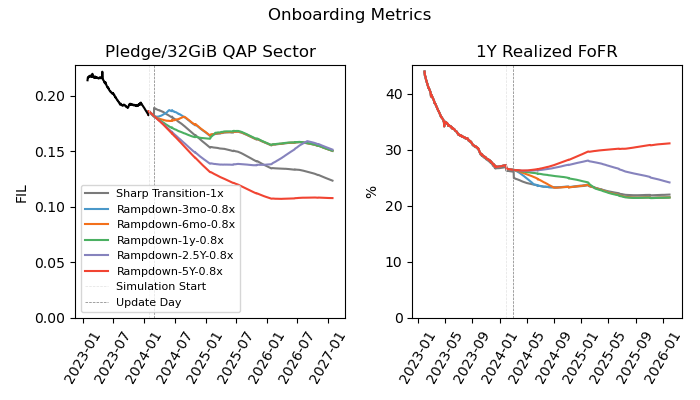

In [15]:
plot_onboarding(simconfig2results)

### Are there incentives to pledge-arbitrage?

In [16]:
ix = 5
label = sim_configs[ix][0]
gamma_config = gammastr2vec[sim_configs[ix][1]]
xx = (simconfig2results[sim_configs[0]]['rb_day_renewed_power_pib']-simconfig2results[sim_configs[ix]]['rb_day_renewed_power_pib'])
yy = simconfig2results[sim_configs[0]]['qa_day_renewed_power_pib']-simconfig2results[sim_configs[ix]]['qa_day_renewed_power_pib']

yy = yy/(1+9*hist_median_fpr)
xx = xx*(1-hist_median_fpr)
zz = yy-xx

ix2title = {
    1: '3mo Ramp',
    2: '6mo Ramp',
    3: '1Y Ramp',
    4: '2.5Y Ramp',
    5: '5Y Ramp',
}

# for 10% arb
ix2rbpfactorsfortvlmatch_pledgearb_rr09 = {
    3: [1.023, 0.91, 0.91],  # 1Y
    4: [1.06, 1.15, 1.07],  # 2.5Y
    5: [1.08, 1.3, 1.65],  # 5Y
}

# for 20% arb
ix2rbpfactorsfortvlmatch_pledgearb_rr08 = {
    1: [1.1, 1.17, 1.17],  # 3mo
    2: [1.1, 1.18, 1.18],  # 6mo
    3: [1.19, 1.17, 1.25],  # 1Y
    4: [1.24, 1.45, 1.42],  # 2.5Y
    5: [1.25, 1.65, 2.1],  # 5Y
}


rbp_factors_rr09 = ix2rbpfactorsfortvlmatch_pledgearb_rr09[ix]
rbp_factors_rr08 = ix2rbpfactorsfortvlmatch_pledgearb_rr08[ix]

#
rr_factor = 0.9
rbp_vec_rr09 = np.ones(forecast_length)
rbp_vec_rr09[0:365] = hist_median_rbp * rbp_factors_rr09[0] + zz[0:365] + xx[0:365]
rbp_vec_rr09[365:730] = hist_median_rbp * rbp_factors_rr09[1] + zz[365:730] * rr_factor + xx[365:730] * rr_factor * rr_factor
rbp_vec_rr09[730:] = hist_median_rbp * rbp_factors_rr09[2] + zz[730:forecast_length]* rr_factor*rr_factor #+ xx[730:forecast_length]* rr_factor*rr_factor

rr_factor = 0.8
rbp_vec_rr08 = np.ones(forecast_length)
rbp_vec_rr08[0:365] = hist_median_rbp * rbp_factors_rr08[0] + zz[0:365] + xx[0:365]
rbp_vec_rr08[365:730] = hist_median_rbp * rbp_factors_rr08[1] + zz[365:730] * rr_factor + xx[365:730] * rr_factor * rr_factor
rbp_vec_rr08[730:] = hist_median_rbp * rbp_factors_rr08[2] + zz[730:forecast_length]* rr_factor*rr_factor #+ xx[730:forecast_length]* rr_factor*rr_factor

In [17]:
rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * 0.9)
fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
simulation_results_rr09 = sim.run_sim(
    rbp_vec_rr09,
    rr_vec,
    fpr_vec,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data,
    gamma=gamma_config,
    gamma_weight_type=0  # means arithmetic weighting
)
# compute total investment level and print
y_val_fil_new = simulation_results_rr09['day_locked_pledge'] - simulation_results_rr09['day_renewed_pledge']
y_val_musd = (y_val_fil_new*FIL_price)/1e6
ix_start = (current_date-start_date).days
investment_needed = np.sum(y_val_musd[ix_start:])
annualized_investment = investment_needed / 3
y1_locked = np.sum(simulation_results_rr09['day_locked_pledge'][ix_start:ix_start+365])/1e6
y2_locked = np.sum(simulation_results_rr09['day_locked_pledge'][ix_start+365:ix_start+2*365])/1e6
y3_locked = np.sum(simulation_results_rr09['day_locked_pledge'][ix_start+2*365:ix_start+3*365])/1e6
total_locked = np.sum(simulation_results_rr09['day_locked_pledge'][ix_start:ix_start+3*365])/1e6
print('>' * 5)
print(np.sum(simulation_results_rr09['day_locked_pledge'][ix_start:])/1e6, np.sum(simulation_results_rr09['day_renewed_pledge'][ix_start:])/1e6)
print('Y1-Locked: %.2fM Y2-Locked: %.2fM Y3-Locked: %.2fM Total-Locked: %.2fM' % (y1_locked, y2_locked, y3_locked, total_locked))
print('AnnualizedInvestment: $%0.2fM' % (annualized_investment,))  # TODO: figure out how much of this is NEW
print('<' * 5)

rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * 0.8)
fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
simulation_results_rr08 = sim.run_sim(
    rbp_vec_rr08,
    rr_vec,
    fpr_vec,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data,
    gamma=gamma_config,
    gamma_weight_type=0  # means arithmetic weighting
)
# compute total investment level and print
y_val_fil_new = simulation_results_rr08['day_locked_pledge'] - simulation_results_rr08['day_renewed_pledge']
y_val_musd = (y_val_fil_new*FIL_price)/1e6
ix_start = (current_date-start_date).days
investment_needed = np.sum(y_val_musd[ix_start:])
annualized_investment = investment_needed / 3
y1_locked = np.sum(simulation_results_rr08['day_locked_pledge'][ix_start:ix_start+365])/1e6
y2_locked = np.sum(simulation_results_rr08['day_locked_pledge'][ix_start+365:ix_start+2*365])/1e6
y3_locked = np.sum(simulation_results_rr08['day_locked_pledge'][ix_start+2*365:ix_start+3*365])/1e6
total_locked = np.sum(simulation_results_rr08['day_locked_pledge'][ix_start:ix_start+3*365])/1e6
print('>' * 5)
print(np.sum(simulation_results_rr08['day_locked_pledge'][ix_start:])/1e6, np.sum(simulation_results_rr08['day_renewed_pledge'][ix_start:])/1e6)
print('Y1-Locked: %.2fM Y2-Locked: %.2fM Y3-Locked: %.2fM Total-Locked: %.2fM' % (y1_locked, y2_locked, y3_locked, total_locked))
print('AnnualizedInvestment: $%0.2fM' % (annualized_investment,))  # TODO: figure out how much of this is NEW
print('<' * 5)


# compare to the case where there was no pledge arbitrage
ix2rbpfactor_nopledgearb = {
    3: (1.1,1.025,1.01),
    4: (1.13,1.22,1.13),
    5: (1.13,1.36,1.6),
}
rbp_factors = ix2rbpfactor_nopledgearb[ix]

rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr)
fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
rbp_vec_rr09 = np.ones(forecast_length)
rbp_vec_rr09[0:365] = hist_median_rbp * rbp_factors[0]
rbp_vec_rr09[365:730] = hist_median_rbp * rbp_factors[1]
rbp_vec_rr09[730:] = hist_median_rbp * rbp_factors[2]
simulation_results_cmp = sim.run_sim(
    rbp_vec_rr09,
    rr_vec,
    fpr_vec,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data,
    gamma=gamma_config,
    gamma_weight_type=0  # means arithmetic weighting
)
# compute total investment level and print
y_val_fil_new = simulation_results_cmp['day_locked_pledge'] - simulation_results_cmp['day_renewed_pledge']
y_val_musd = (y_val_fil_new*FIL_price)/1e6
ix_start = (current_date-start_date).days
investment_needed = np.sum(y_val_musd[ix_start:])
annualized_investment = investment_needed / 3
y1_locked = np.sum(simulation_results_cmp['day_locked_pledge'][ix_start:ix_start+365])/1e6
y2_locked = np.sum(simulation_results_cmp['day_locked_pledge'][ix_start+365:ix_start+2*365])/1e6
y3_locked = np.sum(simulation_results_cmp['day_locked_pledge'][ix_start+2*365:ix_start+3*365])/1e6
total_locked = np.sum(simulation_results_rr09['day_locked_pledge'][ix_start:ix_start+3*365])/1e6
print('>' * 5)
print(np.sum(simulation_results_rr09['day_locked_pledge'][ix_start:])/1e6, np.sum(simulation_results_cmp['day_renewed_pledge'][ix_start:])/1e6)
print('Y1-Locked: %.2fM Y2-Locked: %.2fM Y3-Locked: %.2fM Total-Locked: %.2fM' % (y1_locked, y2_locked, y3_locked, total_locked))
print('AnnualizedInvestment: $%0.2fM' % (annualized_investment,))
print('<' * 5)

>>>>>
481.60013 273.69363
Y1-Locked: 162.84M Y2-Locked: 168.94M Y3-Locked: 149.82M Total-Locked: 481.60M
AnnualizedInvestment: $346.51M
<<<<<
>>>>>
483.3981 244.10736
Y1-Locked: 163.57M Y2-Locked: 169.96M Y3-Locked: 149.87M Total-Locked: 483.40M
AnnualizedInvestment: $398.82M
<<<<<
>>>>>
481.60013 303.3742
Y1-Locked: 162.17M Y2-Locked: 168.30M Y3-Locked: 148.80M Total-Locked: 481.60M
AnnualizedInvestment: $293.16M
<<<<<


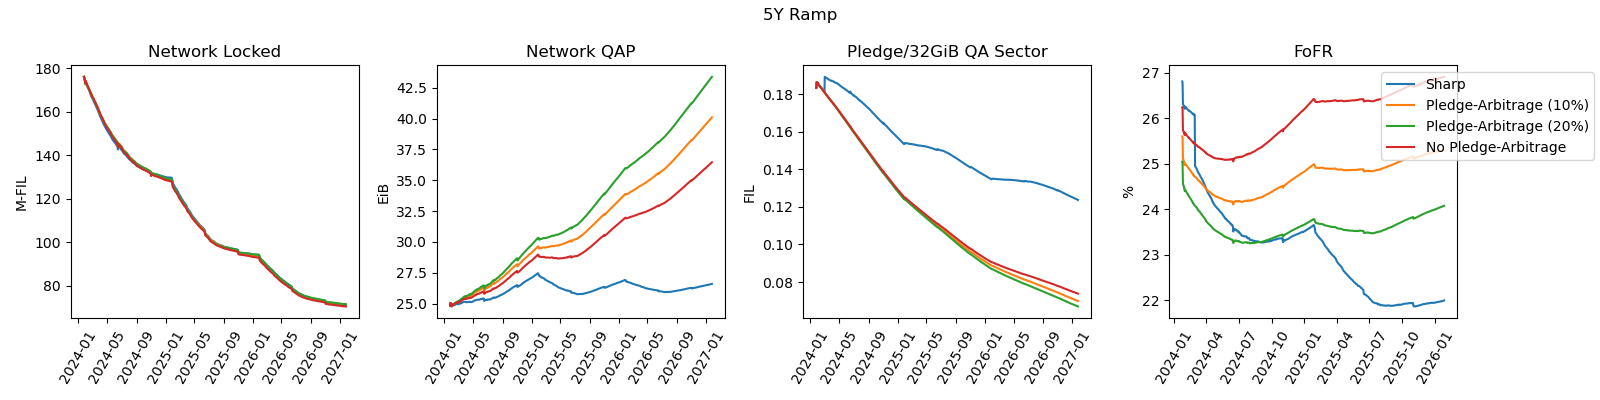

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

axx = ax[0]
axx.plot(macro_t, simconfig2results[sim_configs[0]]['network_locked']/1e6, label='Sharp')
axx.plot(macro_t, simulation_results_rr09['network_locked']/1e6, label='Pledge-Arbitrage (10%)')
axx.plot(macro_t, simulation_results_rr08['network_locked']/1e6, label='Pledge-Arbitrage (20%)')
axx.plot(macro_t, simulation_results_cmp['network_locked']/1e6, label='No Pledge-Arbitrage')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylabel('M-FIL')
axx.set_title('Network Locked')

axx = ax[1]
axx.plot(macro_t, simconfig2results[sim_configs[0]]['qa_total_power_eib'], label='Sharp')
axx.plot(macro_t, simulation_results_rr09['qa_total_power_eib'], label='Pledge-Arbitrage (10%)')
axx.plot(macro_t, simulation_results_rr08['qa_total_power_eib'], label='Pledge-Arbitrage (20%)')
axx.plot(macro_t, simulation_results_cmp['qa_total_power_eib'], label='No Pledge-Arbitrage')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylabel('EiB')
axx.set_title('Network QAP')

axx = ax[2]
axx.plot(macro_t, simconfig2results[sim_configs[0]]['day_pledge_per_QAP'], label='Sharp')
axx.plot(macro_t, simulation_results_rr09['day_pledge_per_QAP'], label='Pledge-Arbitrage (10%)')
axx.plot(macro_t, simulation_results_rr08['day_pledge_per_QAP'], label='Pledge-Arbitrage (20%)')
axx.plot(macro_t, simulation_results_cmp['day_pledge_per_QAP'], label='No Pledge-Arbitrage')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylabel('FIL')
axx.set_title('Pledge/32GiB QA Sector')


axx = ax[3]
days_1y = 365
fofr_t = pd.date_range(start_date, periods=len(simconfig2results[sim_configs[0]]['1y_sector_roi']), freq='D')
axx.plot(fofr_t, 100*simconfig2results[sim_configs[0]]['1y_sector_roi'], label='Sharp')
axx.plot(fofr_t, 100*simulation_results_rr09['1y_return_per_sector']/simulation_results_rr09['day_pledge_per_QAP'][:1-days_1y], label='Pledge-Arbitrage (10%)')
axx.plot(fofr_t, 100*simulation_results_rr08['1y_return_per_sector']/simulation_results_rr08['day_pledge_per_QAP'][:1-days_1y], label='Pledge-Arbitrage (20%)')
axx.plot(fofr_t, 100*simulation_results_cmp['1y_return_per_sector']/simulation_results_cmp['day_pledge_per_QAP'][:1-days_1y], label='No Pledge-Arbitrage')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_title('FoFR')
axx.set_ylabel('%')

plt.suptitle(ix2title[ix])
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'pledge_arb_%d.png' % ix))

### Increase needed without pledge-arb to match TVL

In [19]:
# run the simulations with different configurations of gamma
hist_median_rbp = np.median(historical_rb)
hist_median_rr = np.median(historical_rr)
hist_median_fpr = np.median(historical_fpr)
lock_target = 0.3
sector_duration = 365
FIL_price = 5

sim_configs = [
    ('Sharp Transition', 'sharp', (1.0,1.0,1.0), 1.0, 'Greys', '-'),  # baseline
    ('Rampdown-3mo', 'smooth_3mo', (1.012, 1.005, 1.005), 1.0, 'Blues', '-'),
    ('Rampdown-6mo', 'smooth_6mo', (1.035, 1.005, 1.005), 1.0, 'Oranges', '-'),
    ('Rampdown-1Y', 'smooth_1y', (1.088,1.02,1.015), 1.0, 'Greens', '-'),
    ('Rampdown-2.5Y', 'smooth_2_5y', (1.144,1.22,1.126), 1.0, 'Purples', '-'),
    ('Rampdown-5Y', 'smooth_5y', (1.162,1.377,1.61), 1.0, 'Reds', '-'),
]

simconfig2results = {}
simconfig2investment = {}
simconfig2increases = {}
for zz, sim_config in enumerate(sim_configs):
    gamma_str, gamma_config_str, rbp_factor, rr_factor, _, _ = sim_config
    gamma_config = gammastr2vec[gamma_config_str]

    rbp_vec_rr09 = np.ones(forecast_length)
    rbp_vec_rr09[0:365] = hist_median_rbp * rbp_factor[0]
    rbp_vec_rr09[365:730] = hist_median_rbp * rbp_factor[1]
    rbp_vec_rr09[730:] = hist_median_rbp * rbp_factor[2]

    rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr)
    fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr)
    simulation_results = sim.run_sim(
        rbp_vec_rr09,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data,
        gamma=gamma_config,
        gamma_weight_type=0  # means arithmetic weighting
    )
    simconfig2results[sim_config] = simulation_results

    # compute total investment level and print
    y_val_fil_new = simulation_results['day_locked_pledge'] - simulation_results['day_renewed_pledge']
    y_val_musd = (y_val_fil_new*FIL_price)/1e6
    ix_start = (current_date-start_date).days
    investment_needed = np.sum(y_val_musd[ix_start:])
    annualized_investment = investment_needed / 3
    y1_locked = np.sum(simulation_results['day_locked_pledge'][ix_start:ix_start+365])/1e6
    y2_locked = np.sum(simulation_results['day_locked_pledge'][ix_start+365:ix_start+2*365])/1e6
    y3_locked = np.sum(simulation_results['day_locked_pledge'][ix_start+2*365:ix_start+3*365])/1e6
    total_locked = np.sum(simulation_results['day_locked_pledge'][ix_start:ix_start+3*365])/1e6
    simconfig2investment[sim_config] = annualized_investment

    # compute FoFR increase from baseline
    avg_fofr_increase = 0
    investment_increase = 0
    power_increase_pct = 0
    if zz > 0:
        simulation_results_baseline = simconfig2results[sim_configs[0]]
        baseline_investment = simconfig2investment[sim_configs[0]]
        fofr_increase = (simulation_results['1y_sector_roi'] - simulation_results_baseline['1y_sector_roi']) / simulation_results_baseline['1y_sector_roi'] * 100
        avg_fofr_increase = np.mean(fofr_increase)
        investment_increase = (annualized_investment - baseline_investment) / baseline_investment * 100
        power_increase_pct = (np.mean(rbp_factor) - 1) * 100
        simconfig2increases[gamma_str] = {
            'investment_increase': float(investment_increase),
            'avg_fofr_increase': float(avg_fofr_increase),
            'power_increase_pct': float(power_increase_pct)
        }


    # print('>' * 5)
    # print(sim_config)
    # # print(np.sum(simulation_results['day_locked_pledge'][ix_start:])/1e6, np.sum(simulation_results['day_renewed_pledge'][ix_start:])/1e6)
    # # print('Y1-Locked: %.2fM Y2-Locked: %.2fM Y3-Locked: %.2fM Total-Locked: %.2fM' % (y1_locked, y2_locked, y3_locked, total_locked))
    # # print('AnnualizedInvestment: $%0.2fM' % (annualized_investment,))
    # print('Investment Increase: %0.02f%% FoFR Increase: %.2f%% Power Increase: %0.02f%%' % (investment_increase, avg_fofr_increase, power_increase_pct))
    # print('<' * 5)

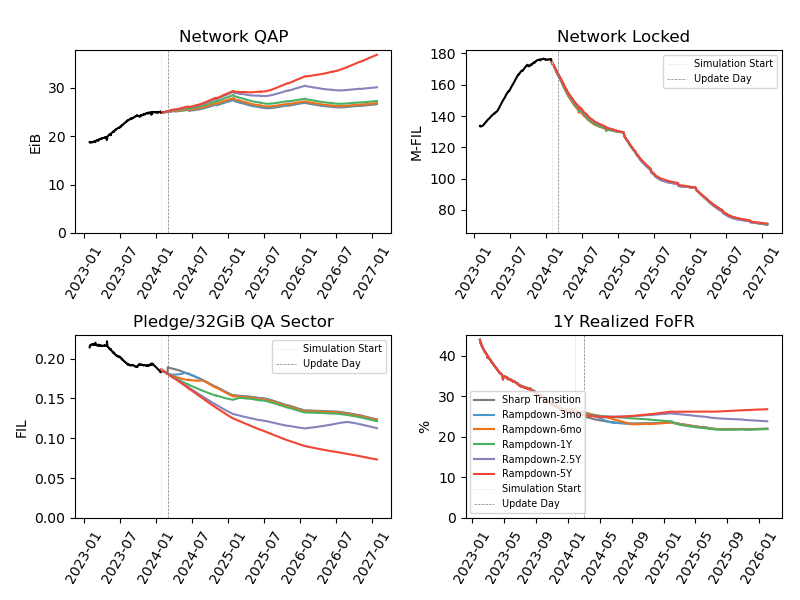

In [20]:
plot_custom3(simconfig2results, '')

In [21]:
simconfig2increases

{'Rampdown-3mo': {'investment_increase': 0.23290294408798218,
  'avg_fofr_increase': 0.1583348512649536,
  'power_increase_pct': 0.7333333333333192},
 'Rampdown-6mo': {'investment_increase': 0.3491564095020294,
  'avg_fofr_increase': 0.47083067893981934,
  'power_increase_pct': 1.4999999999999902},
 'Rampdown-1Y': {'investment_increase': 0.8056574463844299,
  'avg_fofr_increase': 1.5124626159667969,
  'power_increase_pct': 4.100000000000015},
 'Rampdown-2.5Y': {'investment_increase': 1.3086827993392944,
  'avg_fofr_increase': 8.25755500793457,
  'power_increase_pct': 16.333333333333332},
 'Rampdown-5Y': {'investment_increase': 1.3821630477905273,
  'avg_fofr_increase': 12.254542350769043,
  'power_increase_pct': 38.3}}

5
5
5


/tmp/ipykernel_17227/3254334001.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


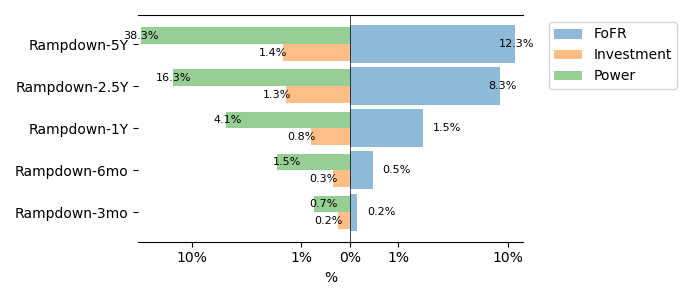

In [22]:
fig, ax, = plt.subplots(figsize=(7,3))
# Original FoFR bars
ax.barh(
    [y for y in range(len(simconfig2increases.keys()))], 
    [v['avg_fofr_increase'] for v in simconfig2increases.values()], 
    label='FoFR', 
    height=0.9,
    alpha=0.5
)
rects = ax.patches
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['avg_fofr_increase'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width + 0.5, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=8)

# Original Investment bars
ax.barh(
    [y-0.2 for y in range(len(simconfig2increases.keys()))], 
    [-v['investment_increase'] for v in simconfig2increases.values()], 
    label='Investment', 
    height=0.4,
    alpha=0.5
)
rects = ax.patches[nr:]
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['investment_increase'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width - 0.2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=8)

# New bars
ax.barh(
    [y+0.2 for y in range(len(simconfig2increases.keys()))], 
    [-v['power_increase_pct'] for v in simconfig2increases.values()],  # Replace 'other_increase' with the actual key
    label='Power',  # Replace 'Other' with the actual label
    height=0.4,
    alpha=0.5
)
rects = ax.patches[nr*2:]
nr = len(rects)
print(nr)
rects = ax.patches[nr*2:]
for rect, label in zip(rects, ['%0.01f%%' % (v['power_increase_pct'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width + 0.2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=8)

ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlabel('%')

ax.set_xscale('symlog')
# set negative xticks to display as positive
xticks = plt.xticks()[0]
xticks = ['%d%%' % abs(x) for x in xticks]
ax.set_xticklabels(xticks)

# Set y-labels to the keys in the dictionary
ax.set_yticks(range(len(simconfig2increases.keys())))
ax.set_yticklabels(simconfig2increases.keys())
# ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

5
5


/tmp/ipykernel_17227/983475620.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


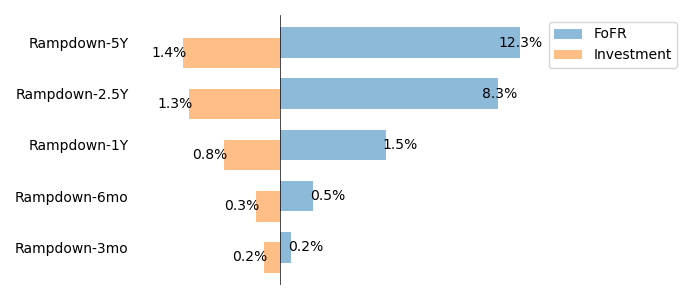

In [23]:
fig, ax, = plt.subplots(figsize=(7,3))
# Original FoFR bars
ax.barh(
    [y for y in range(len(simconfig2increases.keys()))], 
    [v['avg_fofr_increase'] for v in simconfig2increases.values()], 
    label='FoFR', 
    height=0.6,
    alpha=0.5
)
rects = ax.patches
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['avg_fofr_increase'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width + 0.2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=10)

# Original Investment bars
ax.barh(
    [y-0.2 for y in range(len(simconfig2increases.keys()))], 
    [-v['investment_increase'] for v in simconfig2increases.values()], 
    label='Investment', 
    height=0.6,
    alpha=0.5
)
rects = ax.patches[nr:]
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['investment_increase'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width - 0.2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=10)

ax.axvline(0, color='k', linewidth=0.5)
# ax.set_xlabel('%')

ax.set_xscale('symlog')
# set negative xticks to display as positive
xticks = plt.xticks()[0]
xticks = ['%d%%' % abs(x) for x in xticks]
ax.set_xticklabels(xticks)

# Set y-labels to the keys in the dictionary
ax.set_yticks(range(len(simconfig2increases.keys())))
ax.set_yticklabels(simconfig2increases.keys())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'investment_incr.png'))

5
5


/tmp/ipykernel_17227/749898424.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


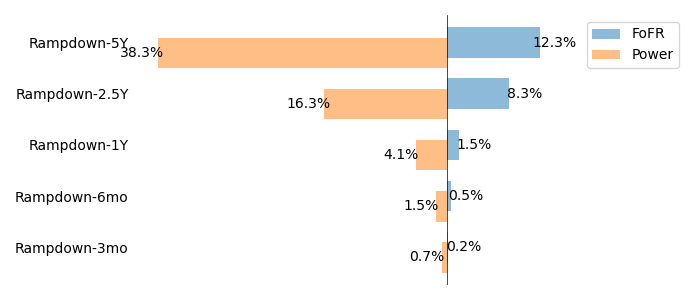

In [24]:
fig, ax, = plt.subplots(figsize=(7,3))
# Original FoFR bars
ax.barh(
    [y for y in range(len(simconfig2increases.keys()))], 
    [v['avg_fofr_increase'] for v in simconfig2increases.values()], 
    label='FoFR', 
    height=0.6,
    alpha=0.5
)
rects = ax.patches
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['avg_fofr_increase'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width + 2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=10)

# Original Investment bars
ax.barh(
    [y-0.2 for y in range(len(simconfig2increases.keys()))], 
    [-v['power_increase_pct'] for v in simconfig2increases.values()], 
    label='Power', 
    height=0.6,
    alpha=0.5
)
rects = ax.patches[nr:]
nr = len(rects)
print(nr)
for rect, label in zip(rects, ['%0.01f%%' % (v['power_increase_pct'],) for v in simconfig2increases.values()]):
    width = rect.get_width()
    ax.text(width - 2, rect.get_y() + rect.get_height() / 2, label, ha='center', va='center', fontsize=10)

ax.axvline(0, color='k', linewidth=0.5)
# ax.set_xlabel('%')

# ax.set_xscale('symlog')
# set negative xticks to display as positive
xticks = plt.xticks()[0]
xticks = ['%d%%' % abs(x) for x in xticks]
ax.set_xticklabels(xticks)

ax.set_yticks(range(len(simconfig2increases.keys())))
ax.set_yticklabels(simconfig2increases.keys())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'power_incr.png'))